# Final Project

### <span style="color:gray"> Violet Davis and Annie Friar </span>

###
`Data Exploration`

---

In [1]:
# Import libraries

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
NORMAL_IMAGE_PATH = '/content/drive/MyDrive/207_final_project/Final_Project_Data/normal/' # Class as 1
GLIOMA_IMAGE_PATH = '/content/drive/MyDrive/207_final_project/Final_Project_Data/glioma_tumor/' # Class as 2
MENINGIOMA_IMAGE_PATH = '/content/drive/MyDrive/207_final_project/Final_Project_Data/meningioma_tumor/' # Class as 3
PITUITARY_IMAGE_PATH = '/content/drive/MyDrive/207_final_project/Final_Project_Data/pituitary_tumor/' # Class as 4

#import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset


In [2]:
indx=0
images = []
labels = []

labels_index = 0

for idx, img in enumerate(os.listdir(NORMAL_IMAGE_PATH)):
    img = load_img(
    NORMAL_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx, [1,0,0,0]))
    labels_index = idx

normal_index = labels_index + 1

for idx, img in enumerate(os.listdir(GLIOMA_IMAGE_PATH)):
    img = load_img(
    GLIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+normal_index, [0,1,0,0]))
    labels_index = idx

glioma_index = normal_index + labels_index + 1

for idx, img in enumerate(os.listdir(MENINGIOMA_IMAGE_PATH)):
    img = load_img(
    MENINGIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+glioma_index, [0,0,1,0]))
    labels_index = idx

meningioma_index = glioma_index + labels_index + 1

for idx, img in enumerate(os.listdir(PITUITARY_IMAGE_PATH)):
    img = load_img(
    PITUITARY_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+meningioma_index, [0,0,0,1]))


In [3]:
labels = np.array(labels)
labels_df = pd.DataFrame(labels,
                   columns=['img_num', 'Label'])

<ipython-input-3-651425286c1d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array(labels)


## From Cornelia's Diabetic Retinopathy Notebook:

As you can see from the histogram above, our dataset is very imbalanced, which is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for starters.

`Correct for data imbalance`

In [4]:
np.random.seed(1234)

n_size = 200


# randomly draw 438 images from each classes
temp_normal = list(np.random.choice(
    normal_index,
    size=n_size,
    replace=False
))

temp_glioma = list(np.random.choice(
    glioma_index,
    size=n_size,
    replace=False
))

temp_meningioma = list(np.random.choice(
    meningioma_index,
    size=n_size,
    replace=False
))


temp_pituitary = list(np.random.choice(
    len(labels),
    size=n_size,
    replace=False
))

In [5]:
image_list = []
labels_list = []

for num in temp_normal:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_glioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_meningioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_pituitary:
    image_list.append(images[num])
    labels_list.append(labels[num])

In [6]:
print("Length of Image List: ", len(image_list))
print("Length of Labels List: ", len(labels_list))

Length of Image List:  800
Length of Labels List:  800


In [7]:
images_mini = []
y_mini = []

for img in image_list:

# transform image to array
    img = img_to_array(img)

    # append to images
    images_mini.append(img)

images_mini = np.stack(images_mini)

for label in labels_list:
    y_mini.append(label[1])

y_mini = np.array(y_mini)

In [8]:
images_mini.shape

(800, 256, 256, 3)

In [9]:
y_mini.shape

(800, 4)

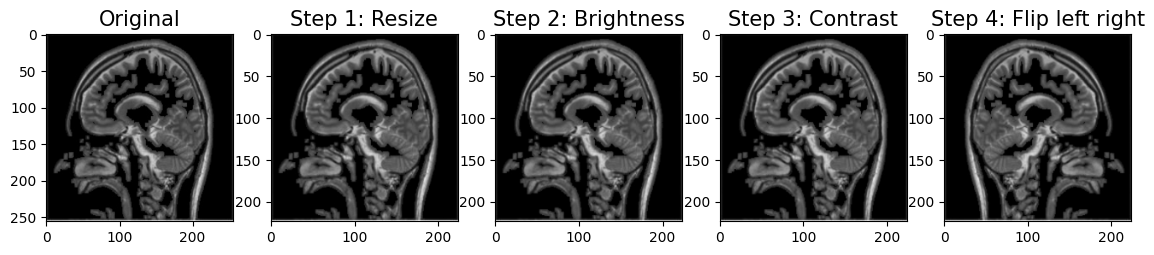

In [10]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [11]:
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0

    return X_train, y_train, X_val, y_val, X_test, y_test

def preprocess_data_part2_aug(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    #X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

    # adjust contrast
    #X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    #X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    #X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    #y_train_augm = y_train
    #y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (480, 256, 256, 1)
y_train shape (480, 4)
X_val shape (160, 256, 256, 1)
y_val shape (160, 4)
X_test shape (160, 256, 256, 1)
y_test shape (160, 4)


In [13]:
validate_split = pd.DataFrame(y_train)

In [14]:
validate_split.value_counts()

0  1  2  3
1  0  0  0    195
0  1  0  0    168
   0  1  0     89
      0  1     28
dtype: int64

## Add in KMeans

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import numpy as np
import pandas

from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse


from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering

In [16]:
X_train.shape

TensorShape([480, 256, 256, 1])

In [17]:
X_flat = np.reshape(X_train, (480, 65536))

In [18]:
X_val.shape

TensorShape([160, 256, 256, 1])

In [19]:
X_v_flat = np.reshape(X_val, (160, 65536))

In [20]:
kmeans = KMeans(n_clusters=10,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
labels = kmeans.fit(X_flat).predict(X_flat)

In [21]:
kmeans_val = KMeans(n_clusters=10,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
labels_val = kmeans_val.fit(X_v_flat).predict(X_v_flat)

In [22]:
X_both_flat = tf.concat([X_flat, X_v_flat],axis=0)

In [23]:
kmeans_both = KMeans(n_clusters=10,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
labels_both = kmeans_both.fit(X_both_flat).predict(X_both_flat)

In [24]:
X_test.shape

TensorShape([160, 256, 256, 1])

In [25]:
X_test_flat = np.reshape(X_test, (160, 65536))

In [26]:
labels_test = kmeans_both.fit(X_test_flat).predict(X_test_flat)

In [27]:
labels.shape

(480,)

## CNN + KMeans Labels as a Feature

In [28]:
def build_CNN_kmeans_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  images = tf.keras.layers.Input(shape=(256, 256, 1), dtype=tf.float32, name='Images')
  kmeans_labels = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='KMeans_Labels')

  features = tf.keras.layers.Add()(
      [images, kmeans_labels])

  conv_1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'
      )(features)

  pool_1 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1')(conv_1)

  conv_2 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu')(pool_1)

  pool_2 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')(conv_2)

  flat = tf.keras.layers.Flatten()(pool_2)

  dense = tf.keras.layers.Dense(
    units=1024,
    name='dense',
    activation='relu')(flat)

  drop = tf.keras.layers.Dropout(
    rate=0.5)(dense)

  preds = tf.keras.layers.Dense(
      units=4, activation='softmax', name='Predictions')(drop)

  model = tf.keras.Model(inputs=[images, kmeans_labels],
                         outputs=preds,
                         name='CNN_KMeans')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss="categorical_crossentropy", #set from_ligits=True because our last layer does not apply sigmoid
      metrics=['accuracy'])

  return model

In [29]:
model_kmeans = build_CNN_kmeans_model()

history = model_kmeans.fit(
  x={
      'Images': X_train,
      'KMeans_Labels': labels
    },
  y=y_train,
  epochs=15,
  validation_data=(
      {
        'Images': X_val,
        'KMeans_Labels': labels_val
      },
      y_val)
)

Epoch 1/15
15/15 [==============================] - 195s 13s/step - loss: 22.1175 - accuracy: 0.3625 - val_loss: 1.3407 - val_accuracy: 0.2000
Epoch 2/15
15/15 [==============================] - 199s 13s/step - loss: 1.4517 - accuracy: 0.4187 - val_loss: 1.3081 - val_accuracy: 0.3375
Epoch 3/15
15/15 [==============================] - 185s 12s/step - loss: 1.2675 - accuracy: 0.3896 - val_loss: 1.5297 - val_accuracy: 0.4125
Epoch 4/15
15/15 [==============================] - 184s 12s/step - loss: 1.2392 - accuracy: 0.4125 - val_loss: 1.3227 - val_accuracy: 0.3187
Epoch 5/15
15/15 [==============================] - 186s 12s/step - loss: 1.1959 - accuracy: 0.4062 - val_loss: 1.5134 - val_accuracy: 0.4125
Epoch 6/15
15/15 [==============================] - 204s 14s/step - loss: 1.1722 - accuracy: 0.3771 - val_loss: 1.5921 - val_accuracy: 0.2250
Epoch 7/15
15/15 [==============================] - 187s 12s/step - loss: 1.1521 - accuracy: 0.4292 - val_loss: 2.4350 - val_accuracy: 0.4125
Epoch

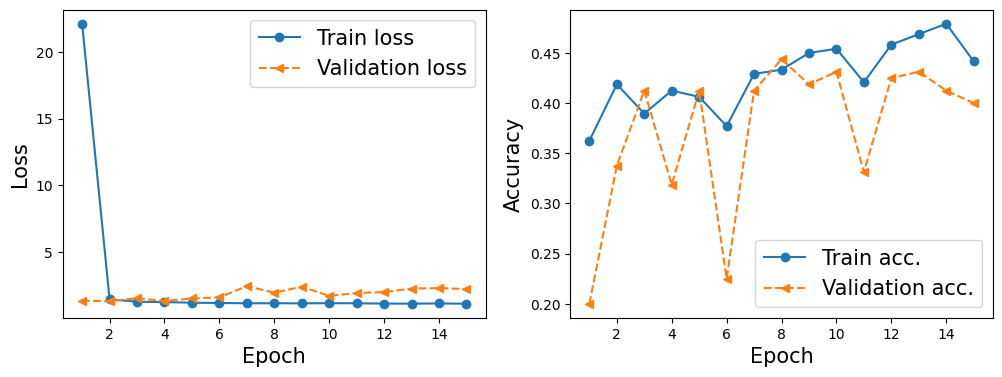

In [30]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [31]:
test_results = model_kmeans.evaluate(x={
    'Images': X_test,
    'KMeans_Labels': labels_test
    }, y=y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

5/5 [==============================] - 13s 3s/step - loss: 1.2113 - accuracy: 0.4625

Test Acc. 46.25%
